In [221]:
"""
Basic Exploratory Data Analysis (EDA) functions
for Party Aggregator project.
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re


party_df = pd.read_csv("../df.csv", parse_dates=["timestamp"])

def contains_hebrew(text):
    return bool(re.search(r'[\u0590-\u05FF]', text))

def reverse_if_hebrew(text):
    return text[::-1] if contains_hebrew(text) else text

/var/folders/fv/k79211k13lqcyqdk75q92xq00000gn/T/ipykernel_31633/3978529008.py:11: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  party_df = pd.read_csv("../df.csv", parse_dates=["timestamp"])


In [222]:
# print(f"df shape: {df.shape}")
# print(f"df columns: {df.columns}")
# print(f"df dtypes: {df.dtypes}")

# 1. Remove duplicate rows
party_df = party_df.drop_duplicates()

# 2. Convert timestamp to datetime
party_df["timestamp"] = pd.to_datetime(party_df["timestamp"], errors="coerce")  # coerce bad formats to NaT

# 3. Normalize string columns
string_cols = ["arrived_marker", "file_id", "folder_name", "full_name", "special_requests", "song_requests"]

for col in string_cols:
    party_df[col] = party_df[col].astype(str).str.strip()  # remove leading/trailing spaces
    party_df[col] = party_df[col].str.replace(r"\s+", " ", regex=True)  # replace multiple spaces with single space

party_df["arrived"] = party_df["arrived"].astype("boolean")  # Nullable BooleanDtype

# 4. Replace blank strings with NaN in relevant text fields
party_df[["special_requests", "song_requests"]] = party_df[["special_requests", "song_requests"]].replace(r"^\s*$", pd.NA, regex=True)

# 5. Convert folder names to categorical
party_df["folder_name"] = party_df["folder_name"].astype("category")

# print(f"df dtypes: {df.dtypes}")

/var/folders/fv/k79211k13lqcyqdk75q92xq00000gn/T/ipykernel_31633/2678336164.py:9: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  party_df["timestamp"] = pd.to_datetime(party_df["timestamp"], errors="coerce")  # coerce bad formats to NaT


In [223]:
# party_df[['arrived_marker', 'full_name']].groupby(['arrived_marker']).count()
# party_df

# Song Requests

In [224]:
party_df["song_requests_clean"] = (
    party_df["song_requests"]
    .replace(["", " ", "NA", "NaN", "nan", "n/a", None], pd.NA)
    .astype("string")  # nullable string dtype
    .str.strip()
    .str.lower()
)

### Percentage of song request across parties

/var/folders/fv/k79211k13lqcyqdk75q92xq00000gn/T/ipykernel_31633/2236609292.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  party_df.groupby("folder_name")


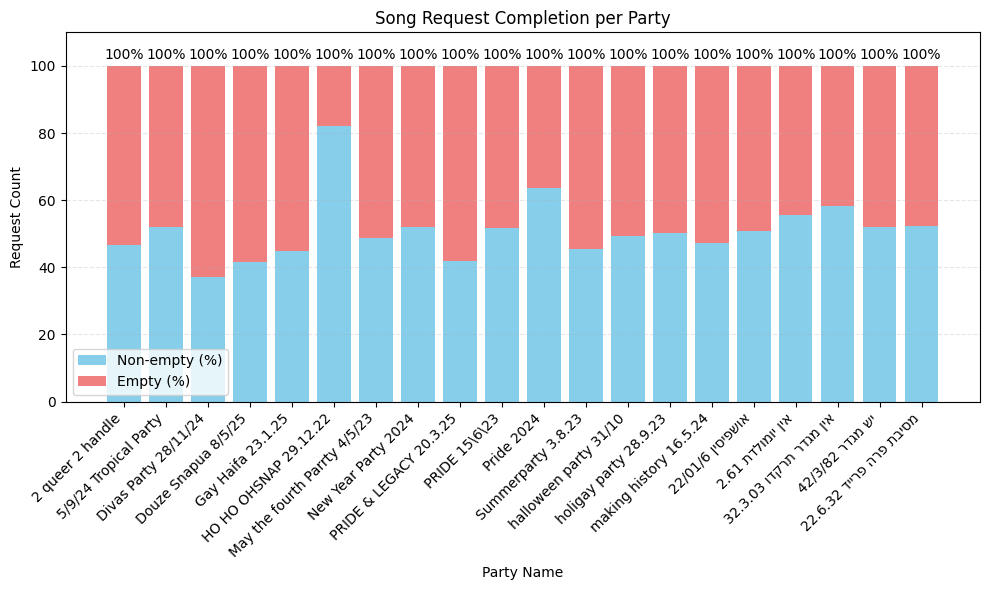

In [225]:
g_df = (
    party_df.groupby("folder_name")
    .agg(
        non_empty_requests=("song_requests", "count"),
        total_requests=("song_requests", lambda x: x.str.strip().ne("").count()),
    )
    .reset_index()
)

# Add empty + percentage
g_df["percent_filled"] = (g_df["non_empty_requests"] / g_df["total_requests"]) * 100
g_df["percent_empty"] = 100 - g_df["percent_filled"]

# Reverse Hebrew folder names for display
g_df["folder_name_display"] = g_df["folder_name"].apply(reverse_if_hebrew)

# Plot stacked bar chart with labels
plt.figure(figsize=(10, 6))
bars1 = plt.bar(g_df["folder_name_display"], g_df["percent_filled"], label="Non-empty (%)", color='skyblue')
bars2 = plt.bar(g_df["folder_name_display"], g_df["percent_empty"], bottom=g_df["percent_filled"], label="Empty (%)", color='lightcoral')

# Add percentage labels (always 100% height)
for i, bar in enumerate(bars1):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        102,
        "100%",
        ha='center',
        fontsize=10,
        color='black'
    )

plt.title("Song Request Completion per Party")
plt.xlabel("Party Name")
plt.ylabel("Request Count")
plt.ylim(0, 110)  # Add padding above 100%
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

### Stop words

In [226]:
from stop_words import get_stop_words

he_stop_words_df = pd.read_csv("../top_3000_most_freq_wiki.csv", header=None)
hebrew_stop_words = set(he_stop_words_df[1].astype(str).str.strip())

# Combine English and Hebrew stop words
en_stop_words = set(get_stop_words('en'))
he_stop_words = set(hebrew_stop_words)
all_stop_words = en_stop_words.union(he_stop_words)

def tokenize_and_filter(text):
    # protect against missing/NA values
    if pd.isna(text):
        return []
    # Tokenize with regex to support Hebrew + English
    tokens = re.findall(r'\b\w+\b', text, flags=re.UNICODE)
    # Keep only non-stop words and alphabetic tokens
    return [t for t in tokens if t not in all_stop_words and t.isalpha() and len(t) > 2]

party_df["song_request_tokens"] = party_df["song_requests_clean"].apply(tokenize_and_filter)

# df[["song_requests", "song_requests_clean", "song_request_tokens"]].sample(5)

### Unigram Analysis

In [227]:
from collections import Counter

# Flatten all token lists and count
all_tokens = [token for tokens in party_df["song_request_tokens"] for token in tokens]
token_counts = Counter(all_tokens)
top_tokens = token_counts.most_common(50)  # top N

# Convert to DataFrame for display/export
global_freq_df = pd.DataFrame(top_tokens, columns=["token", "count"])

import matplotlib.pyplot as plt

from collections import defaultdict

# Group by party → accumulate token frequencies
party_token_counts = defaultdict(Counter)

for _, row in party_df.iterrows():
    party = row["folder_name"]
    tokens = row["song_request_tokens"]
    party_token_counts[party].update(tokens)

# Convert to tidy DataFrame
rows = []
for party, counts in party_token_counts.items():
    for token, count in counts.items():
        rows.append({"party": party, "token": token, "count": count})

party_freq_df = pd.DataFrame(rows)

# Plot top token globally
def plot_top_tokens(freq_df, top_n=10, title="Top Song Request Tokens"):
    freq_df["token"] = freq_df["token"].apply(reverse_if_hebrew)
    top_df = freq_df.nlargest(top_n, "count")
    plt.figure(figsize=(15, 5))
    plt.bar(top_df["token"], top_df["count"], color="orchid")
    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel("Token")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle="--", alpha=0.3)
    # plt.tight_layout()
    plt.show()

# Plot top tokens by party
def get_top_tokens_by_party(df, top_n=10):
    return (
        df.sort_values(["party", "count"], ascending=[True, False])
        .groupby("party")
        .head(top_n)
        .reset_index(drop=True)
    )


# plot_top_tokens(global_freq_df, top_n=30, title="Top 50 Global Song Request Tokens")
# get_top_tokens_by_party(party_freq_df[party_freq_df["party"] == "PRIDE & LEGACY 20.3.25"], top_n=10)

### N-grams Analysis (Bag of Words)

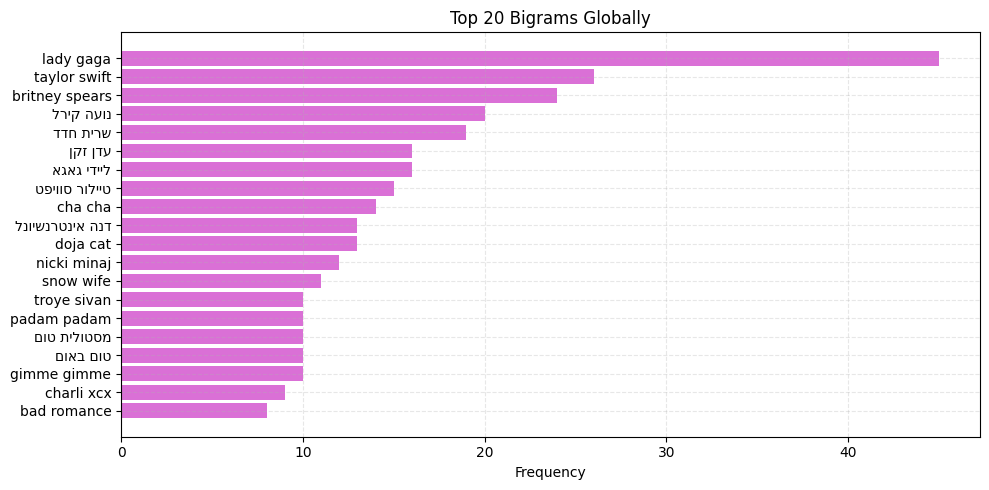

In [229]:
from nltk.util import ngrams

def generate_ngrams(tokens, n=2):
    return [' '.join(gram) for gram in ngrams(tokens, n)]

party_df["bigrams"] = party_df["song_request_tokens"].apply(lambda tokens: generate_ngrams(tokens, 2))
party_df["trigrams"] = party_df["song_request_tokens"].apply(lambda tokens: generate_ngrams(tokens, 3))

from collections import Counter

def get_top_ngrams(df, col_name="bigrams", top_n=20):
    all_ngrams = [ng for row in df[col_name] for ng in row]
    ngram_counts = Counter(all_ngrams)
    return pd.DataFrame(ngram_counts.most_common(top_n), columns=[col_name, "count"])

top_bigrams_df = get_top_ngrams(party_df, col_name="bigrams", top_n=20)
top_trigrams_df = get_top_ngrams(party_df, col_name="trigrams", top_n=20)

def plot_ngrams(df, col_name, title="Top N-grams", color="orchid"):
    df[col_name] = df[col_name].apply(reverse_if_hebrew)
    plt.figure(figsize=(10, 5))
    plt.barh(df[col_name], df["count"], color=color)
    plt.title(title)
    plt.xlabel("Frequency")
    plt.gca().invert_yaxis()  # highest at top
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()
    
plot_ngrams(top_bigrams_df,"bigrams", title="Top 20 Bigrams Globally")
# plot_ngrams(top_trigrams_df,"trigrams", title="Top 20 Trigrams Globally", color="teal")